### 1.목표
- 문제정의
- 500명의 키와 몸무게 그리고 비만도를 이용해서 비만을 판단하는 모델을 만들어보자
- 머신러닝의 전체적인 과정을 이해해보자
  

In [1]:
# 필요한 도구를 불러오자!
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier #knn분류 모델
from sklearn.metrics import accuracy_score #정확도 평가 도구


- 데이터 준비하기
  

In [2]:
data = pd.read_csv("./bmi_500.csv", decimal=",")
data

,Gender,Height,Weight,Label
0,Male,174,96,Obesity
1,Male,189,87,Normal
2,Female,185,110,Obesity
3,Female,195,104,Overweight
4,Male,149,61,Overweight
...,...,...,...,...
495,Female,150,153,Extreme Obesity
496,Female,184,121,Obesity
497,Female,141,136,Extreme Obesity
498,Male,150,95,Extreme Obesity


In [3]:
# 데이터 프레임의 정보를 확인
# info()
# 전체 행, 컬럼 정보, 결측치 여부
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  500 non-null    object
 1   Height  500 non-null    int64 
 2   Weight  500 non-null    int64 
 3   Label   500 non-null    object
dtypes: int64(2), object(2)
memory usage: 15.8+ KB


- 전처리 : 학습용으로 제공된 데이터 -> 이미 깔끔하게 전처리가 되어있다!
  

- 탐색적 데이터 분석(EDA) : 기술통계량 확인, 상관관계 확인, 그래프 시각화

In [4]:
# 기슬 통계 확인
data.describe()

,Height,Weight
count,500.000000,500.000000
mean,169.944000,106.000000
std,16.375261,32.382607
min,140.000000,50.000000
25%,156.000000,80.000000
50%,170.500000,106.000000
75%,184.000000,136.000000
max,199.000000,160.000000


In [5]:
# 답 데이터 살펴보기
# 답 레이블 중복없이 확인해보기

data2 = data.set_index('Label') # 인덱스 설정 함수
data2.index.unique()

# 'Extreme Obesity' : 고도 비만
#'Obesity' : 비만
# 'Overweight' : 과체중
# 'Normal' : 정상
# 'Weak', : 저체중
# 'Extremely Weak' : 극심한 저체중
# 클래스의 개수가 총 6개

Index(['Obesity', 'Normal', 'Overweight', 'Extreme Obesity', 'Weak',
       'Extremely Weak'],
      dtype='object', name='Label')

In [6]:
# 클래스별로 몇개씩 들어있을까?
data2.index.value_counts()

# 머신러닝 학습시 답 레이블의 균형을 맞춰주는 것이 학습에 도움이 된다.

Extreme Obesity    198
Obesity            130
Normal              69
Overweight          68
Weak                22
Extremely Weak      13
Name: Label, dtype: int64

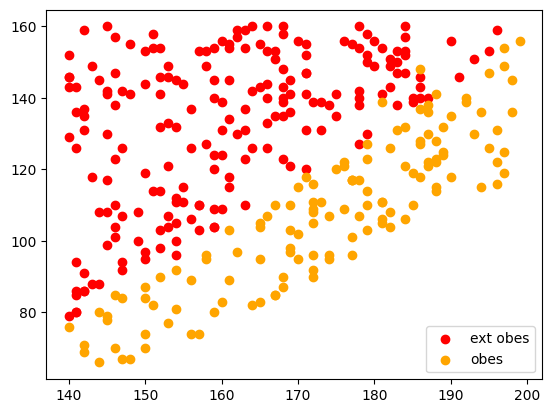

In [7]:
# 시각화
# x축에는 키, y축 몸무게, 산점도(점 찍어서 분포 확인하는 그래프) 
# Extreme Obesity
# 행(index, 문자열) 값에 쉽게 접근하게 하는 인덱서 => loc

# d.index.unique()
import matplotlib.pyplot as plt
d = data2.loc["Extreme Obesity"]
plt.scatter(x =d["Height"], y=d["Weight"],c='red', label="ext obes")

d = data2.loc["Obesity"]
plt.scatter(x =d["Height"], y=d["Weight"],c='orange', label="obes")
plt.legend() #범례 표시(출력)
plt.show()

In [8]:
# 그래프 그리는 함수 생성(정의)

def bmi_draw(label, color):
    d = data2.loc[label]
    plt.scatter(x =d["Height"], y=d["Weight"], c=color, label=label)

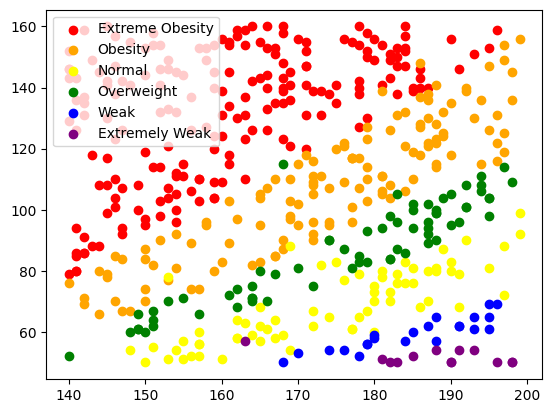

In [17]:
# 클래스 별로 실행하면서, 하나의 도화지에 모든 점을 그려보기 (호출)
bmi_draw("Extreme Obesity","red")
bmi_draw("Obesity","orange")
bmi_draw("Normal","yellow")
bmi_draw("Overweight","green")
bmi_draw("Weak","blue")
bmi_draw("Extremely Weak","purple")
plt.legend()
plt.show()


- 모델링 

In [20]:
# 추후에 더 배우게 될 knn 모델 불러오기
# 정확도 평가하는 함수(기능) 불러오기
# metrics 모델 성능 평가 지표

from sklearn.neighbors import KNeighborsClassifier # 분류 모델
from sklearn.metrics import accuracy_score # 정확도 평가 지표 함수


In [23]:
data.head()

,Gender,Height,Weight,Label
0,Male,174,96,Obesity
1,Male,189,87,Normal
2,Female,185,110,Obesity
3,Female,195,104,Overweight
4,Male,149,61,Overweight


In [53]:
# 지도 학습 : 문제와 답
# 머신러닝 모델 : 학습 -> 평가 및 예측
# 학습용 데이터 셋 (문제, 답)
# 테스트용 데이터 셋 (문제, 답)

# 7:3 통상적으로 분리하는 비율
# 8:2, 7.5:2.5도 가능

# 0 ~ 350 -> 트레인용
# 학습용 데이터
X_train = data.loc[:349,"Height":'Weight']#훈련용 문제
# X_train = data.iloc[:350,1:3]
y_train = data.loc[:349,"Label"]# 훈련용 답
# y_train = data.loc[:350,-1]


# 350 ~ 500 -> 테스트 용
# 테스트용 데이터
X_test = data.loc[350:,"Height":'Weight']  #테스트용 문제
# X_train = data.iloc[350:,1:3]
y_test =data.loc[350:,"Label"] #테스트용 답
# y_train = data.loc[350:,-1]



In [55]:
# 크기 확인
print("훈련용 문제 : ",X_train.shape)
print("훈련용 답 : ",y_train.shape)
print("테스트용 문제 : ",X_test.shape)
print("테스트용 답 : ",y_test.shape)

훈련용 문제 :  (350, 2)
훈련용 답 :  (350,)
테스트용 문제 :  (150, 2)
테스트용 답 :  (150,)


In [114]:
# 모델 생성
knn_model = KNeighborsClassifier() # 이웃 5개 확인하는 상황

In [115]:
# 모델 학습
# fit : 맞추다
# 데이터에 맞춰서 학습한다라는 의미
knn_model.fit(X_train, y_train)


KNeighborsClassifier()

In [118]:
# 예측
pre = knn_model.predict(X_test)
pre

array(['Overweight', 'Normal', 'Normal', 'Extreme Obesity',
       'Extremely Weak', 'Obesity', 'Obesity', 'Extreme Obesity', 'Weak',
       'Extreme Obesity', 'Weak', 'Extreme Obesity', 'Extreme Obesity',
       'Obesity', 'Extreme Obesity', 'Obesity', 'Overweight', 'Obesity',
       'Extreme Obesity', 'Obesity', 'Overweight', 'Extreme Obesity',
       'Weak', 'Normal', 'Obesity', 'Extreme Obesity', 'Extreme Obesity',
       'Extreme Obesity', 'Obesity', 'Overweight', 'Extreme Obesity',
       'Weak', 'Obesity', 'Extreme Obesity', 'Extreme Obesity', 'Weak',
       'Extreme Obesity', 'Obesity', 'Overweight', 'Normal', 'Normal',
       'Normal', 'Normal', 'Overweight', 'Extreme Obesity', 'Overweight',
       'Overweight', 'Extreme Obesity', 'Overweight', 'Extreme Obesity',
       'Overweight', 'Obesity', 'Normal', 'Obesity', 'Obesity',
       'Extreme Obesity', 'Normal', 'Extreme Obesity', 'Extreme Obesity',
       'Extreme Obesity', 'Weak', 'Obesity', 'Extreme Obesity',
       'Extreme

In [119]:
# 정확도 평가 지표
accuracy_score(y_test, pre)

0.9066666666666666

In [ ]:
# 모델 저장, 실제 서비스 단에서 사용